In [ ]:
import string
import random
from random import randint
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
import re
from matplotlib import pyplot as plt
import math

### Set up environment folders

In [ ]:
# Run this command only once:

# makes the output folder /content/pictures/
!mkdir pictures
!mkdir training_data
!mkdir augmented_training_data

In [ ]:
# Run this command only once

# Downloads the license plate template to /content/blank_plate.png
!gdown --id 1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v
To: /content/blank_plate.png
100% 144k/144k [00:00<00:00, 106MB/s]


### Create training data

In [ ]:
path = "/content/"

NUMBER_OF_PLATES = 500

for i in range(0, NUMBER_OF_PLATES):

    # Pick two random letters
    plate_alpha = ""
    for _ in range(0, 2):
        plate_alpha += (random.choice(string.ascii_uppercase))

    # Pick two random numbers
    num = randint(0, 99)
    plate_num = "{:02d}".format(num)

    # Write plate to image
    blank_plate = cv2.imread(path+'blank_plate.png')

    # Convert into a PIL image (this is so we can use the monospaced fonts)
    blank_plate_pil = Image.fromarray(blank_plate)

    # Get a drawing context
    draw = ImageDraw.Draw(blank_plate_pil)
    monospace = ImageFont.truetype(font="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 
                                   size=165)
    draw.text(xy=(48, 75),
              text=plate_alpha + " " + plate_num, 
              fill=(255,0,0), font=monospace)

    # Convert back to OpenCV image and save
    blank_plate = np.array(blank_plate_pil)

    # Write license plate to file
    cv2.imwrite(os.path.join(path + "pictures/", 
                             "plate_{}{}.png".format(plate_alpha, plate_num)),
                             blank_plate)

### Generate training dataset

In [ ]:
def files_in_folder(folder_path):
  '''
  Returns a list of strings where each entry is a file in the folder_path.
  
  Parameters
  ----------
  
  folder_path : str
     A string to folder for which the file listing is returned.
     
  '''
  files_A = !ls "{folder_path}"
  # The files when listed from Google Drive have a particular format. They are
  # grouped in sets of 4 and have spaces and tabs as delimiters.
  
  # Split the string listing sets of 4 files by tab and space and remove any 
  # empty splits.
  files_B = [list(filter(None, re.split('\t|\s', files))) for files in files_A]
  
  # Concatenate all splits into a single sorted list
  files_C = []
  for element in files_B:
    files_C = files_C + element
  files_C.sort()
  
  return files_C

In [ ]:
for f in files_in_folder(path+"/pictures/"):
  picture = np.array(cv2.imread(path+"/pictures/"+f))
  letter_first = picture[75:230, 45:145, :]
  letter_second = picture[75:230, 145:245, :]
  number_first = picture[75:230, 345:445, :]
  number_second = picture[75:230, 445:545, :]

  cv2.imwrite(path+"/training_data/"+f[6]+".png", letter_first)
  cv2.imwrite(path+"/training_data/"+f[7]+".png", letter_second)
  cv2.imwrite(path+"/training_data/"+f[8]+".png", number_first)
  cv2.imwrite(path+"/training_data/"+f[9]+".png", number_second)

In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y
  
def convert_to_new_alphabet(n):
  i = ord(n)

  if i <= 57:
    return i - 48
  else:
    return i - 65

In [ ]:
# Imports
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend
import tensorflow.image as tfimg

In [ ]:
IMG_SIZE = (30, 30, 1)

In [ ]:
def mask_from_img_for_augmentation(image):
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  lower_blue = np.array([100,100,20])
  upper_blue = np.array([140,255,255])
  mask = cv2.inRange(hsv, lower_blue, upper_blue)

  mask = mask.astype(np.uint8)
  return mask


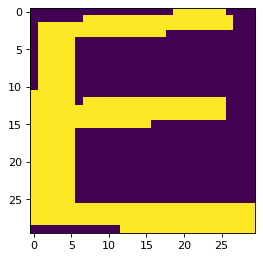

In [ ]:
def random_quadranple(pts1):
    pts2 = []
    for i in range(4):
      rana = random.randint(-3, 3)
      ranb = random.randint(-3, 3)
      pts2.append([pts1[i, 0] + rana, pts1[i, 1] + ranb])
    return np.float32(pts2)
    
def data_aug(img):
  vert_resize = random.randint(100, 170)
  images = cv2.resize(img, (100, vert_resize))
  pts1 = np.float32([[20, 20], [20, 70], [80, 20], [80, 70]])

  pts2 = random_quadranple(pts1)
  M = cv2.getPerspectiveTransform(pts1,pts2)
  images = np.array(images, dtype = np.uint8)
  images = cv2.warpPerspective(images,M,(100, vert_resize))
  
  mask = mask_from_img_for_augmentation(images)
  
  (x,y,w,h) = cv2.boundingRect(mask)
  images = images[y:y+h, x:x+w]

  rand = random.randint(0, 2)
  if rand == 2:
    images = cv2.resize(np.array(images), (30, 30))
  else:
    images = cv2.resize(np.array(images), (10, 10))
    images = cv2.GaussianBlur(images, (3,3), 0)

  images = cv2.resize(np.array(images), (IMG_SIZE[1], IMG_SIZE[0]))
  images = mask_from_img_for_augmentation(images)

  return np.array(images)

files = files_in_folder(path+"training_data/")
a = data_aug(cv2.imread(path+"/training_data/"+files[14]))
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.subplot(1, 2, 1)
plt.imshow(a)

In [ ]:
def find_max_area_contour(cnt, hierarchy):
  max_area = 0
  ind = 0

  for i in range(len(cnt)):
    area = cv2.contourArea(cnt[i])
    if area > max_area and hierarchy[0, i, -1] == -1:
      max_area = area
      ind = i
  
  return cnt[ind], ind
    

In [ ]:
def banner_mask(image):
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  lower = np.array([0,0,90])
  upper = np.array([0,0,220])
  mask = cv2.inRange(hsv, lower, upper)

  mask = mask.astype(np.uint8)
  return mask

In [ ]:
def real_data_augmentation(image):
  row, column, ch = image.shape
  mask = banner_mask(image)
  cnts, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
 
  cnts = list(cnts)
  cnt1, ind = find_max_area_contour(cnts, hierarchy)
  del cnts[ind]
  hierarchy = np.array([np.delete(hierarchy[0], ind, axis = 0)])
  cnt2, ind = find_max_area_contour(cnts, hierarchy)
  
  banner_contour = [cv2.boundingRect(cnt1), cv2.boundingRect(cnt2)]
  if banner_contour[0][1] > banner_contour[1][1]:
    banner_contour = [banner_contour[1], banner_contour[0]]
  
  crop = image[banner_contour[0][1]:banner_contour[1][1]+banner_contour[1][3], 
                 banner_contour[1][0] + 3:banner_contour[1][0]+banner_contour[1][2] - 3]
  mask_crop = mask_from_img_for_augmentation(crop)

  # Use kmeans to find the letters
  arr = []
  for i in range(mask_crop.shape[0]):
    for j in range(mask_crop.shape[1]):
      if mask_crop[i][j] == 255:
        arr.append([i, j])

  arr = np.float32(np.array(arr))
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
  ret,label,center=cv2.kmeans(arr,4,None,criteria,20,cv2.KMEANS_RANDOM_CENTERS)

  datapoints = []
  boxes = []

  for i in range(4):
    temp = arr[label.ravel() == i]
    datapoints.append(temp)

  for points in datapoints:
    (xa,ya,wa,ha) = cv2.boundingRect(points)
    boxes.append(np.array((xa,ya,wa,ha)))
  
  # Sorting the letters from left to right
  for i in range(len(boxes)):
    low_val = column
    low_index = 0
    for j in range(i, len(boxes)):
      cent = boxes[j][1] + boxes[j][3]/2
      if cent < low_val:
        low_val = cent
        low_index = j
    
    temp = boxes[i]
    boxes[i] = boxes[low_index]
    boxes[low_index] = temp

  imges = []
    
  for box in boxes:
    imges.append(crop[box[0]:box[0]+box[2], box[1]:box[1]+box[3]])

  for img in imges:
    mask = mask_from_img_for_augmentation(img)

    b = []
    cnts, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt, ind = find_max_area_contour(cnts, hierarchy)
    b = cv2.boundingRect(cnt)

    mask = mask[b[1]:b[1]+b[3], b[0]:b[0]+b[2]]
    mask = cv2.resize(mask, (IMG_SIZE[1], IMG_SIZE[0]))

    random_str = ''.join(random.choice(string.ascii_lowercase) for i in range(10))
    cv2.imwrite('/content/augmented_training_data/!'+random_str+".png", mask)
  

In [ ]:
files = files_in_folder(path+"training_data/")

for file in files:
  img = cv2.imread(path+"training_data/"+file)
  for i in range(800):
    aug = data_aug(img)
    cv2.imwrite(path+"augmented_training_data/"+file[0]+str(i)+".png", aug)


In [ ]:
files = files_in_folder(path+"augmented_training_data/")

training_set_char = []
training_set_num = []
for file in files[:]:
  if ord(file[0]) <= 57:
    training_set_num.append(np.array([np.array(Image.open(path+"/augmented_training_data/"+file)), convert_to_new_alphabet(file[0])]))
  else:
    training_set_char.append(np.array([np.array(Image.open(path+"/augmented_training_data/"+file)), convert_to_new_alphabet(file[0])]))
np.random.shuffle(training_set_num)
np.random.shuffle(training_set_char)

inputSet_orig_num = np.array([data[0] for data in training_set_num])
outputSet_orig_num = np.array([[data[1]] for data in training_set_num])
inputSet_orig_char = np.array([data[0] for data in training_set_char])
outputSet_orig_char = np.array([[data[1]] for data in training_set_char])

# Normalize X (images) dataset
inputSet_num = inputSet_orig_num/255.
inputSet_char = inputSet_orig_char/255.

# Convert Y dataset to one-hot encoding
outputSet_num = convert_to_one_hot(outputSet_orig_num, 10)

outputSet_char = convert_to_one_hot(outputSet_orig_char, 26)

<ipython-input-17-01560e86eead>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_set_num.append(np.array([np.array(Image.open(path+"/augmented_training_data/"+file)), convert_to_new_alphabet(file[0])]))
<ipython-input-17-01560e86eead>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_set_char.append(np.array([np.array(Image.open(path+"/augmented_training_data/"+file)), convert_to_new_alphabet(file[0])]))


### Create neural network

In [ ]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=IMG_SIZE))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (2, 2), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dense(10, activation='softmax'))

conv_model.summary()

char_model = models.Sequential()
char_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=IMG_SIZE))
char_model.add(layers.MaxPooling2D((2, 2)))
char_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
char_model.add(layers.MaxPooling2D((2, 2)))
char_model.add(layers.Conv2D(128, (2, 2), activation='relu'))
char_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
char_model.add(layers.Flatten())
char_model.add(layers.Dropout(0.5))
char_model.add(layers.Dense(512, activation='relu'))
char_model.add(layers.Dense(26, activation='softmax'))

char_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

In [ ]:
LEARNING_RATE = 1e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['acc'])

char_model.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['acc'])

In [ ]:
history_conv = conv_model.fit(inputSet_num, outputSet_num, 
                              validation_split=0.1, 
                              epochs=15, 
                              batch_size=64)


Epoch 1/15
113/113 [==============================] - 9s 8ms/step - loss: 0.3633 - acc: 0.8981 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 2/15
113/113 [==============================] - 1s 5ms/step - loss: 0.0135 - acc: 0.9960 - val_loss: 5.2560e-04 - val_acc: 1.0000
Epoch 3/15
113/113 [==============================] - 1s 5ms/step - loss: 0.0070 - acc: 0.9974 - val_loss: 9.7702e-05 - val_acc: 1.0000
Epoch 4/15
113/113 [==============================] - 1s 5ms/step - loss: 0.0031 - acc: 0.9994 - val_loss: 2.5220e-04 - val_acc: 1.0000
Epoch 5/15
113/113 [==============================] - 1s 5ms/step - loss: 0.0028 - acc: 0.9994 - val_loss: 3.2783e-05 - val_acc: 1.0000
Epoch 6/15
113/113 [==============================] - 1s 5ms/step - loss: 0.0040 - acc: 0.9985 - val_loss: 5.2553e-04 - val_acc: 1.0000
Epoch 7/15
113/113 [==============================] - 1s 5ms/step - loss: 0.0026 - acc: 0.9990 - val_loss: 0.0039 - val_acc: 0.9987
Epoch 8/15
113/113 [==============================] - 1s

In [ ]:
history_char = char_model.fit(inputSet_char, outputSet_char, 
                              validation_split=0.1, 
                              epochs=20, 
                              batch_size=64)

Epoch 1/20
293/293 [==============================] - 2s 6ms/step - loss: 0.4409 - acc: 0.8593 - val_loss: 0.0902 - val_acc: 0.9683
Epoch 2/20
293/293 [==============================] - 1s 5ms/step - loss: 0.0924 - acc: 0.9663 - val_loss: 0.0598 - val_acc: 0.9764
Epoch 3/20
293/293 [==============================] - 1s 5ms/step - loss: 0.0690 - acc: 0.9757 - val_loss: 0.0725 - val_acc: 0.9740
Epoch 4/20
293/293 [==============================] - 1s 5ms/step - loss: 0.0553 - acc: 0.9797 - val_loss: 0.0335 - val_acc: 0.9861
Epoch 5/20
293/293 [==============================] - 1s 5ms/step - loss: 0.0500 - acc: 0.9817 - val_loss: 0.0349 - val_acc: 0.9885
Epoch 6/20
293/293 [==============================] - 1s 5ms/step - loss: 0.0401 - acc: 0.9860 - val_loss: 0.0315 - val_acc: 0.9885
Epoch 7/20
293/293 [==============================] - 1s 5ms/step - loss: 0.0375 - acc: 0.9868 - val_loss: 0.0275 - val_acc: 0.9918
Epoch 8/20
293/293 [==============================] - 1s 5ms/step - loss: 0.

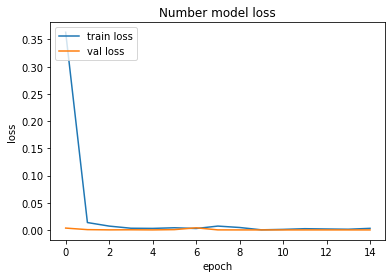

In [ ]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('Number model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

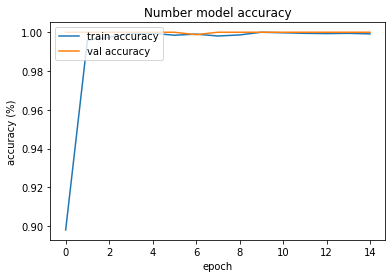

In [ ]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('Number model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

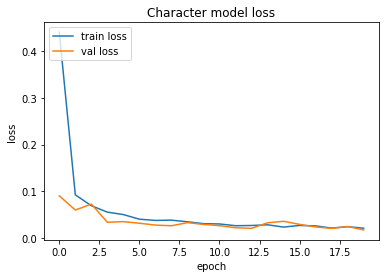

In [ ]:
plt.plot(history_char.history['loss'])
plt.plot(history_char.history['val_loss'])
plt.title('Character model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

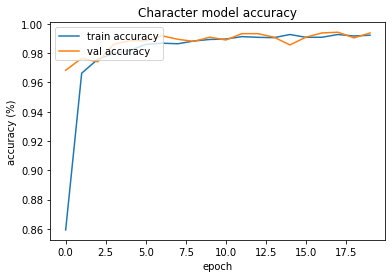

In [ ]:
plt.plot(history_char.history['acc'])
plt.plot(history_char.history['val_acc'])
plt.title('Character model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

### Test model

In [ ]:
testPicture = np.array(Image.open(path+"pictures/plate_AD98.png"))
segments = [testPicture[75:230, 45:145, :], testPicture[75:230, 145:245, :], 
            testPicture[75:230, 345:445, :], testPicture[75:230, 445:545, :]]

result = []

for pic in segments:
  aug = data_aug(pic)
  img_aug = np.expand_dims(aug/255., axis=0)
  predict = conv_model.predict(img_aug)[0]
  result.append(np.argmax(predict))

for i in range(2):
  result[i] = chr(result[i] + 55)

for i in range(2,4):
  result[i] = chr(result[i] + 48)

print(result)



FileNotFoundError: ignored

In [ ]:
def mask_from_img(image):
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  lower_blue = np.array([100,100,20])
  upper_blue = np.array([140,255,255])
  mask = cv2.inRange(hsv, lower_blue, upper_blue)

  mask = mask.astype(np.uint8)
  return mask

In [ ]:
def find_parking_ID(image):
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  lower_black = np.array([0,0,0])
  upper_black = np.array([0,0,60])
  mask = cv2.inRange(hsv, lower_black, upper_black)

  return mask.astype(np.uint8)

1/1 [==============================] - 0s 141ms/step
[1.7810385e-03 4.8485659e-02 1.1641664e-13 1.9210664e-10 9.4444716e-01
 5.2860887e-03 9.1568147e-08 1.5117821e-13 5.1104151e-12 3.3630183e-08]
1/1 [==============================] - 0s 61ms/step
[3.82277758e-05 7.34395813e-04 5.76364546e-11 1.05423004e-08
 1.79447943e-06 4.37690278e-06 4.28546976e-09 4.85740378e-02
 1.09286402e-09 3.65674602e-08 1.17600742e-07 3.53366374e-07
 9.50526655e-01 4.15936707e-09 3.07268692e-07 1.10352215e-04
 5.44787078e-08 1.78055015e-10 1.36020806e-09 6.22469853e-09
 7.91243906e-07 1.28703814e-09 3.77462968e-08 1.22776683e-07
 3.54281525e-07 7.91583989e-06]
1/1 [==============================] - 0s 14ms/step
[6.3911020e-06 2.0890757e-06 4.2222146e-04 2.4942861e-07 3.2262155e-01
 6.7601329e-01 5.1576039e-04 2.6293721e-06 1.2650546e-05 2.5770257e-08
 3.0972683e-06 1.6399683e-05 2.7264552e-05 1.1948158e-05 4.4385702e-06
 8.4853091e-05 1.5746058e-06 2.6260316e-06 2.0564719e-04 3.6181893e-05
 5.4760454e-09 2.7

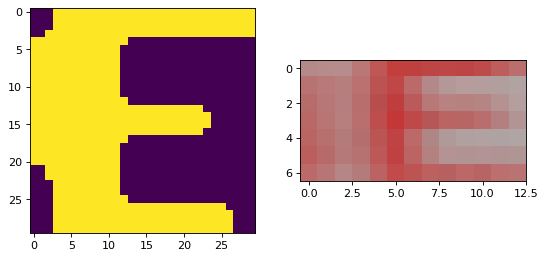

In [ ]:
def predict_v2(image):
  row, column, ch = image.shape
  mask = banner_mask(image)
  cnts, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
 
  cnts = list(cnts)
  cnt1, ind = find_max_area_contour(cnts, hierarchy)
  del cnts[ind]
  hierarchy = np.array([np.delete(hierarchy[0], ind, axis = 0)])
  cnt2, ind = find_max_area_contour(cnts, hierarchy)
  
  banner_contour = [cv2.boundingRect(cnt1), cv2.boundingRect(cnt2)]
  if banner_contour[0][1] > banner_contour[1][1]:
    banner_contour = [banner_contour[1], banner_contour[0]]
  
  crop = image[banner_contour[0][1]:banner_contour[1][1]+banner_contour[1][3], 
                 banner_contour[1][0] + 3:banner_contour[1][0]+banner_contour[1][2] - 3]
  mask_crop = mask_from_img(crop)
  
  mask_parking_ID = find_parking_ID(crop)

  # Find letters in Parking ID
  cnts_parking_id, hierarchy = cv2.findContours(mask_parking_ID, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
 
  cnts_parking_id = list(cnts_parking_id)

  cnt_parking_id1, ind = find_max_area_contour(cnts_parking_id, hierarchy)
  del cnts_parking_id[ind]
  hierarchy = np.array([np.delete(hierarchy[0], ind, axis = 0)])
  cnt_parking_id2, ind = find_max_area_contour(cnts_parking_id, hierarchy)
  box_parking_ID = [cv2.boundingRect(cnt_parking_id1), 
                    cv2.boundingRect(cnt_parking_id2)]

  if box_parking_ID[0][0] > box_parking_ID[1][0]:
    box_parking_ID = [box_parking_ID[1], box_parking_ID[0]]
  img_parking_ID = []

  for box in box_parking_ID:
    img_parking_ID.append(crop[box[1]:box[1]+box[3], box[0]:box[0]+box[2]])

  # Use kmeans to find the letters
  arr = []
  for i in range(mask_crop.shape[0]):
    for j in range(mask_crop.shape[1]):
      if mask_crop[i][j] == 255:
        arr.append([i, j])

  arr = np.float32(np.array(arr))
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
  ret,label,center=cv2.kmeans(arr,4,None,criteria,20,cv2.KMEANS_RANDOM_CENTERS)

  datapoints = []
  boxes = []

  for i in range(4):
    temp = arr[label.ravel() == i]
    datapoints.append(temp)

  for points in datapoints:
    (xa,ya,wa,ha) = cv2.boundingRect(points)
    boxes.append(np.array((xa,ya,wa,ha)))
  
  # Sorting the letters from left to right
  for i in range(len(boxes)):
    low_val = column
    low_index = 0
    for j in range(i, len(boxes)):
      cent = boxes[j][1] + boxes[j][3]/2
      if cent < low_val:
        low_val = cent
        low_index = j
    
    temp = boxes[i]
    boxes[i] = boxes[low_index]
    boxes[low_index] = temp

  result = []
  imges = []
  pred = []
    
  for box in boxes:
    imges.append(crop[box[0]:box[0]+box[2], box[1]:box[1]+box[3]])
  
  # Predict Parking ID
  pred_img = find_parking_ID(img_parking_ID[1])
  pred_img = cv2.resize(pred_img, (IMG_SIZE[1], IMG_SIZE[0]))
  pred_img = np.around(pred_img/255)
  pred_img = np.expand_dims(pred_img, axis=0)
  predict = conv_model.predict(pred_img)[0]
  print(predict)
  result_parking_ID = np.argmax(predict)

  # Predict character
  for i in range(2):
    pred_img = mask_from_img(imges[i])

    b = []
    cnts, hierarchy = cv2.findContours(pred_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    ind = 0
    for i in range(len(cnts)):
      area = cv2.contourArea(cnts[i])
      if area > max_area:
        max_area = area
        ind = i
    b = cv2.boundingRect(cnts[ind])
      
    pred_img = pred_img[b[1]:b[1]+b[3], b[0]:b[0]+b[2]]
    pred_img = cv2.resize(pred_img, (IMG_SIZE[1], IMG_SIZE[0]))
    pred_img = np.around(pred_img/255)
    pred_img = np.array(pred_img*255)

    pred.append(pred_img)
    pred_img = np.expand_dims(pred_img/255., axis=0)
    predict = char_model.predict(pred_img)[0]

    print(predict)
    result.append(np.argmax(predict))
  
  # Predict number
  for i in range(2,4):
    pred_img = mask_from_img(imges[i])

    b = []
    cnts, hierarchy = cv2.findContours(pred_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    ind = 0
    for i in range(len(cnts)):
      area = cv2.contourArea(cnts[i])
      if area > max_area:
        max_area = area
        ind = i
    b = cv2.boundingRect(cnts[ind])
      
    pred_img = pred_img[b[1]:b[1]+b[3], b[0]:b[0]+b[2]]
    pred_img = cv2.resize(pred_img, (IMG_SIZE[1], IMG_SIZE[0]))
    pred_img = np.around(pred_img/255)
    pred_img = np.array(pred_img*255)

    pred.append(pred_img)
    pred_img = np.expand_dims(pred_img/255., axis=0)
    predict = conv_model.predict(pred_img)[0]
    print(predict)
    result.append(np.argmax(predict))

  for i in range(2):
    result[i] = chr(result[i] + 65)
  for i in range(2,4):
    result[i] = chr(result[i] + 48)
  result_parking_ID = chr(result_parking_ID + 48)

  print(result)
  print(result_parking_ID)
  return pred, imges

img = cv2.imread("/content/bdgmjgfu.png")
a, b = predict_v2(img)

pos = 1
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.subplot(1, 2, 1)
plt.imshow(a[pos])
plt.subplot(1, 2, 2)
plt.imshow(b[pos])
plt.show()

1/1 [==============================] - 0s 16ms/step
[5.7054240e-11 5.0413860e-09 9.9998879e-01 1.1028641e-05 8.0502893e-09
 1.0379430e-12 1.1774620e-14 7.3071611e-09 1.4045176e-10 8.2672408e-08]
1/1 [==============================] - 0s 16ms/step
[3.02758082e-07 9.99999404e-01 5.06084410e-12 9.66747820e-08
 1.44606416e-09 7.14962554e-14 7.21776861e-09 8.70679386e-08
 6.39092121e-12 1.52800672e-09 8.11347083e-12 2.14018100e-15
 1.51789301e-08 8.15314992e-13 3.93204758e-09 9.24060689e-11
 4.29606439e-09 3.68898495e-10 1.01363149e-08 3.51800132e-13
 8.24942267e-11 5.47439481e-12 7.17325640e-14 1.02587955e-11
 2.07727542e-12 6.50606369e-09]
1/1 [==============================] - 0s 16ms/step
[1.0000000e+00 2.0478108e-09 7.8581040e-17 1.5872637e-11 7.1409858e-15
 7.7535372e-15 4.9921079e-12 3.2812858e-13 7.6351035e-12 4.3370307e-11
 9.9871439e-14 1.4402912e-15 1.5137940e-12 9.8244394e-13 2.7430252e-12
 1.8296474e-09 5.6552413e-10 8.1088200e-12 4.3487474e-13 3.8751998e-11
 5.0668809e-17 1.13

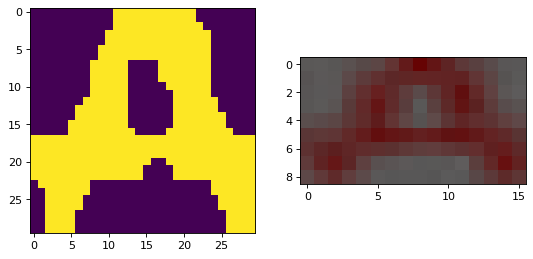

In [ ]:
def predict(image):
  row, column, ch = image.shape
  cropped_img = image[int(0):row, :, :]

  mask = mask_from_img(cropped_img)
  cnts, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  blobs = 0
  cm = []
  big_contour = []
  for c in cnts:
    area = cv2.contourArea(c)

    if(area > 400):
      M = cv2.moments(c)
      if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        cm.append((cx, cy))
      big_contour.append(c)
      blobs += 1
    
  # Finding the two contour that represent the car in interest
  pair = (0, 0)
  distance = 10000000000
  for i in range(len(cm)):
    for j in range(len(cm)):
      d = (cm[i][0] - cm[j][0])**2 + (cm[i][1] - cm[j][1])**2
      if d < distance and d != 0:
        distance = d
        pair = (i, j)
  
  cm = [cm[pair[0]], cm[pair[1]]]
  car_contour = [big_contour[pair[0]], big_contour[pair[1]]]
  if cm[0][0] > cm[1][0]:
    cm = [cm[1], cm[0]]
    car_contour = [car_contour[1], car_contour[0]]
  
  # Finding the white banner on the parked cars
  (x1,y1,w1,h1) = cv2.boundingRect(car_contour[0])
  (x2,y2,w2,h2) = cv2.boundingRect(car_contour[1])

  top_left = [x1 + w1, y1]
  bottom_right = [x2, y2 + h2]
  
  crop = cropped_img[top_left[1]: bottom_right[1], top_left[0]:bottom_right[0]]
  mask_crop = mask_from_img(crop)
  
  mask_parking_ID = find_parking_ID(crop)

  # Removing noise
  cnts, hierarchy = cv2.findContours(mask_crop, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  for c in cnts:
    area = cv2.contourArea(c)
    if area < 10:
      mask_crop = cv2.drawContours(mask_crop, [c], -1, (0,0,0), -1)

  # Find letters in Parking ID
  cnts_parking_id, hierarchy = cv2.findContours(mask_parking_ID, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
 
  cnts_parking_id = list(cnts_parking_id)

  cnt_parking_id1, ind = find_max_area_contour(cnts_parking_id, hierarchy)
  del cnts_parking_id[ind]
  hierarchy = np.array([np.delete(hierarchy[0], ind, axis = 0)])
  cnt_parking_id2, ind = find_max_area_contour(cnts_parking_id, hierarchy)
  box_parking_ID = [cv2.boundingRect(cnt_parking_id1), 
                    cv2.boundingRect(cnt_parking_id2)]

  if box_parking_ID[0][0] > box_parking_ID[1][0]:
    box_parking_ID = [box_parking_ID[1], box_parking_ID[0]]
  img_parking_ID = []

  for box in box_parking_ID:
    img_parking_ID.append(crop[box[1]:box[1]+box[3], box[0]:box[0]+box[2]])

  # Use kmeans to find the letters
  arr = []
  for i in range(mask_crop.shape[0]):
    for j in range(mask_crop.shape[1]):
      if mask_crop[i][j] == 255:
        arr.append([i, j])

  arr = np.float32(np.array(arr))
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
  ret,label,center=cv2.kmeans(arr,4,None,criteria,20,cv2.KMEANS_RANDOM_CENTERS)

  datapoints = []
  boxes = []

  for i in range(4):
    temp = arr[label.ravel() == i]
    datapoints.append(temp)

  for points in datapoints:
    (xa,ya,wa,ha) = cv2.boundingRect(points)
    boxes.append(np.array((xa,ya,wa,ha)))
  
  # Sorting the letters from left to right
  for i in range(len(boxes)):
    low_val = column
    low_index = 0
    for j in range(i, len(boxes)):
      cent = boxes[j][1] + boxes[j][3]/2
      if cent < low_val:
        low_val = cent
        low_index = j
    
    temp = boxes[i]
    boxes[i] = boxes[low_index]
    boxes[low_index] = temp

  result = []
  imges = []
  pred = []
    
  for box in boxes:
    imges.append(crop[box[0]:box[0]+box[2], box[1]:box[1]+box[3]])
  
  # Predict Parking ID
  pred_img = find_parking_ID(img_parking_ID[1])
  pred_img = cv2.resize(pred_img, (IMG_SIZE[1], IMG_SIZE[0]))
  pred_img = np.around(pred_img/255)
  pred_img = np.expand_dims(pred_img, axis=0)
  predict = conv_model.predict(pred_img)[0]
  print(predict)
  result_parking_ID = np.argmax(predict)

  # Predict character
  for i in range(2):
    pred_img = mask_from_img(imges[i])

    b = []
    cnts, hierarchy = cv2.findContours(pred_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    ind = 0
    for i in range(len(cnts)):
      area = cv2.contourArea(cnts[i])
      if area > max_area:
        max_area = area
        ind = i
    b = cv2.boundingRect(cnts[ind])
      
    pred_img = pred_img[b[1]:b[1]+b[3], b[0]:b[0]+b[2]]
    pred_img = cv2.resize(pred_img, (IMG_SIZE[1], IMG_SIZE[0]))
    pred_img = np.around(pred_img/255)
    pred_img = np.array(pred_img*255)

    pred.append(pred_img)
    pred_img = np.expand_dims(pred_img/255., axis=0)
    predict = char_model.predict(pred_img)[0]

    print(predict)
    result.append(np.argmax(predict))
  
  # Predict number
  for i in range(2,4):
    pred_img = mask_from_img(imges[i])

    b = []
    cnts, hierarchy = cv2.findContours(pred_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    ind = 0
    for i in range(len(cnts)):
      area = cv2.contourArea(cnts[i])
      if area > max_area:
        max_area = area
        ind = i
    b = cv2.boundingRect(cnts[ind])
      
    pred_img = pred_img[b[1]:b[1]+b[3], b[0]:b[0]+b[2]]
    pred_img = cv2.resize(pred_img, (IMG_SIZE[1], IMG_SIZE[0]))
    pred_img = np.around(pred_img/255)
    pred_img = np.array(pred_img*255)

    pred.append(pred_img)
    pred_img = np.expand_dims(pred_img/255., axis=0)
    predict = conv_model.predict(pred_img)[0]
    print(predict)
    result.append(np.argmax(predict))

  for i in range(2):
    result[i] = chr(result[i] + 65)
  for i in range(2,4):
    result[i] = chr(result[i] + 48)
  result_parking_ID = chr(result_parking_ID + 48)

  print(result)
  print(result_parking_ID)
  return pred, imges

img = cv2.imread("/content/bdgmjgfu.png")
a, b = predict(img)

pos = 1
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.subplot(1, 2, 1)
plt.imshow(a[pos])
plt.subplot(1, 2, 2)
plt.imshow(b[pos])
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

files = files_in_folder(path+"pictures/")
result_char = []
result_num = []
true_char = []
true_num = []

for f in files:
  testPicture = np.array(Image.open(path+"/pictures/" + f))
  segments = [testPicture[75:230, 45:145, :], testPicture[75:230, 145:245, :], 
              testPicture[75:230, 345:445, :], testPicture[75:230, 445:545, :]]
  for i in range(2):
    true_char.append(f[6+i])
  for i in range(2, 4):
    true_num.append(f[6+i])

  i = 0
  for pic in segments:
    pic = cv2.cvtColor(pic, cv2.COLOR_RGB2BGR)
    pic  = data_aug(pic)
    img_aug = np.expand_dims(pic/255., axis=0)
    if i < 2:
      predict = char_model.predict(img_aug)[0]
      result_char.append(np.argmax(predict))
    else:
      predict = conv_model.predict(img_aug)[0]
      result_num.append(np.argmax(predict))
    i += 1

1/1 [==============================] - 0s 15ms/step


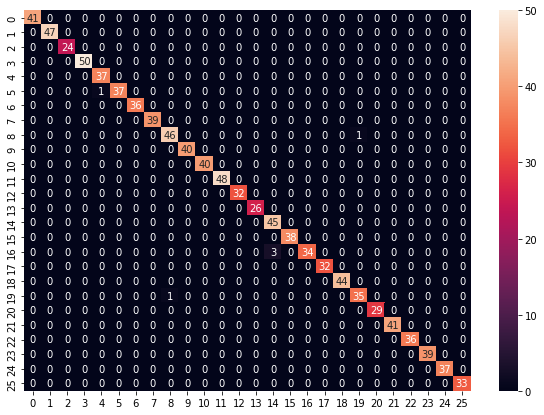

In [ ]:
for i in range(len(true_num)):
  true_num[i] = convert_to_new_alphabet(true_num[i])
for i in range(len(true_char)):
  true_char[i] = convert_to_new_alphabet(true_char[i])

c = confusion_matrix(true_char, result_char)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(c, index = [i for i in range(26)],
                  columns = [i for i in range(26)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

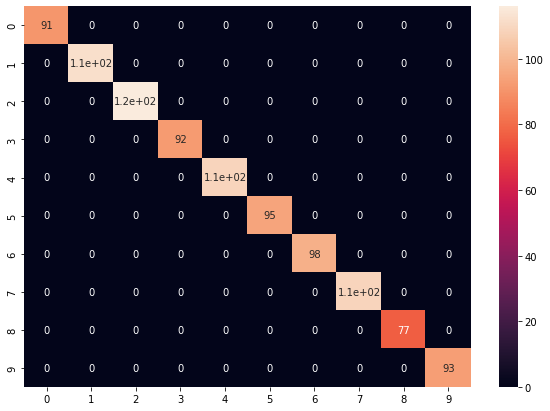

In [ ]:
c1 = confusion_matrix(true_num, result_num)

df_cm1 = pd.DataFrame(c1, index = [i for i in range(10)],
                  columns = [i for i in range(10)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm1, annot=True)

In [ ]:
conv_model.save("/content/num_detect.h5")
char_model.save("/content/char_detect.h5")

In [ ]:
conv_model = models.load_model('/content/num_detect.h5')
char_model = models.load_model('/content/char_detect.h5')

In [ ]:
conv_model.save_weights("/content/num_detect")
char_model.save_weights("/content/char_detect")